<a href="https://colab.research.google.com/github/sujitpal/anago/blob/master/03_01_sequence_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Networks for Sequence Learning

__NOTE: Please set runtime type to GPU for this notebook.__

Recurrent Neural Networks are a class of neural networks specialized for sequential data (text, speech, video, etc).

Fully connected or Dense networks consume the entire input at once. Convolution networks take advantage of the hierarchical nature of the input. Recurrent networks have a mechanism to "remember" the value of inputs from previous time steps.


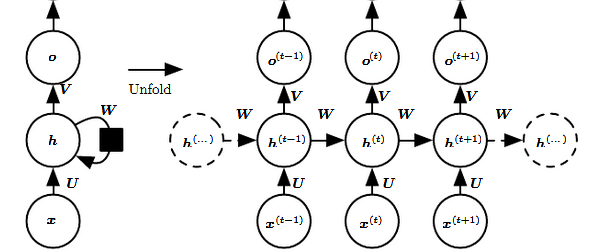

In equations, an RNN can be defined as follows:

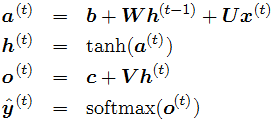

where:

* x(t) -- input to RNN at time step t.
* h(t) -- hidden state at time t, based on current input x(t) and previous time step hidden state h(t-1). This is passed through a non-linearity such as tanh.
* o(t) -- output of the network at time step t.
* $\hat{y}(t)$ -- prediction of network at time step t.

Loss L is negative log likelihood of true target y(t) given input so far. Loss for sequence is sum of loss over all time steps.


In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow.keras as keras

%matplotlib inline

## RNN Example

In this example, we will train a sentiment classifier using the IMDB data built into `tf.keras.datasets`.

Input to the network would be a sequence of tokens, or more correctly, indexes of the tokens in the corpus vocabulary.

Predictions (and labels) for each input sequence is either a 0 (negative sentiment) or 1 (positive sentiment).


### Data

The IMDB dataset is a set of movie reviews labeled with positive or negative sentiment.

The dataset has already parsed through the text, extracted the vocabulary, and converted each review document into a sequence of integers, that are indexes into the vocabulary.

The Xtrain and Xtest are jagged lists. Each element of Xtrain and Xtest is a list of integers, where the integers are the indices in the word index (in `get_word_index`).

The ytrain and ytest are just 0 or 1.

### Decisions about data

* The full vocabulary contains 88,584 words, but in order to keep our model small, we will use the most frequent 20,000 only.
* Words that are less frequent will be replaced by the OOV character (indicated by 2).
* Usually, we would choose a maximum sequence length (number of tokens) that would balance the model size with input data coverage, but here we will set it to 128.
* Added advantage of this is that shorter sequences are left-padded with zeros (the PAD character) automatically.
* The `get_word_index` does not have a concept of `start_char`, so we need to handle it ourself.



In [3]:
word_index = keras.datasets.imdb.get_word_index()
len(word_index)

1646592/1641221 [==============================] - 0s 0us/step


88584

In [4]:
MAX_SEQUENCE_LENGTH = 128

(Xtrain, ytrain), (Xtest, ytest) = keras.datasets.imdb.load_data(
    num_words=20000, oov_char=1, index_from=2, maxlen=MAX_SEQUENCE_LENGTH)

# converts the text from list of list of tokens to 2D array
Xtrain = keras.preprocessing.sequence.pad_sequences(Xtrain, maxlen=MAX_SEQUENCE_LENGTH)
Xtest = keras.preprocessing.sequence.pad_sequences(Xtest, maxlen=MAX_SEQUENCE_LENGTH)

ytrain = ytrain.reshape(-1, 1)
ytest = ytest.reshape(-1, 1)

Xtrain.shape, ytrain.shape, Xtest.shape, ytest.shape

17465344/17464789 [==============================] - 0s 0us/step


((5833, 128), (5833, 1), (6228, 128), (6228, 1))

In [5]:
idx2word = {v+1:k for k, v in word_index.items() if v <= 20000}
idx2word[0] = "__PAD__"
idx2word[1] = "__OOV__"
word2idx = {v:k for k, v in idx2word.items()}

len(word_index), len(idx2word), len(word2idx)

(88584, 20002, 20002)

In [6]:
# recreating the first document by vocabulary lookup
" ".join([idx2word[i] for i in Xtrain[0]])

'__PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __PAD__ __OOV__ actual your we i english nothing was and surprising plug office __OOV__ at first work out her watching go did shots huge in in vampire again and theater __OOV__ as joey is and bit really i about better you kessler in in'

## Model 1: basic RNN (LSTM)

We send in our sequence through an embedding layer, which projects the sparse vocabulary input vector indicated by the sequence of token_ids into a dense embedding space __which is learned during training__.

Each token is converted into a dense vector via the `Embedding` layer, which is fed into a bidirectional LSTM, one LSTM reading left to right and the other reading right to left.

LSTM is an advanced version of RNN, which helps to combat the __vanishing gradient__ or "forgetting" problem of standard RNNs.

A bidirectional LSTM is really two LSTMs, one reading the input sequence left to right, and the other reading it right to left. Keras allows you to declare this using a `Bidirectional` layer wrapper.

The output of the LSTM can be a sequence if `return_sequences=True` or a single "context vector" if `return_sequences=False` (default).

The single context vector is fed into a `Dense` layer with a 1-unit output, which operates as a Binary classifier.

Because we are doing binary classifier, our loss function is `binary_crossentropy`.

We train this for 5 epochs, with 20% of the training data set aside for end-of-epoch validation.

In [7]:
def build_model_1():
  inputs = keras.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32")
  # project input from vocab id to 300d embedding space, specify input length
  x = keras.layers.Embedding(len(word2idx), 300, 
                             input_length=MAX_SEQUENCE_LENGTH,
                             mask_zero=True)(inputs)
  # embedding vector for each input token feeds into Bidirectional LSTM of
  # hidden size 64 (since bidirectional 64*2 = 128)
  x = keras.layers.Bidirectional(keras.layers.LSTM(64))(x)
  # context vector from LSTM (return_sequences=False) into Dense binary classifier
  outputs = keras.layers.Dense(1, activation="sigmoid")(x)

  model = keras.models.Model(inputs, outputs)

  model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

  return model


model_1 = build_model_1()
model_1.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 128, 300)          6000600   
_________________________________________________________________
bidirectional (Bidirectional (None, 128)               186880    
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 6,187,609
Trainable params: 6,187,609
Non-trainable params: 0
_________________________________________________________________


In [8]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss")
model_checkpoint = keras.callbacks.ModelCheckpoint("/tmp/model_1", 
                                                   monitor="val_loss", 
                                                   save_best_only=True)
history_1 = model_1.fit(Xtrain, ytrain, batch_size=32, epochs=5, 
                        validation_split=0.2,
                        callbacks=[early_stopping, model_checkpoint])

Epoch 1/5
146/146 [==============================] - ETA: 0s - loss: 0.4665 - accuracy: 0.7606WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/training/tracking/tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /tmp/model_1/assets
146/146 [==============================] - 107s 735ms/step - loss: 0.4665 - accuracy: 0.7606 - val_loss: 0.3259 - val_accuracy: 0.8655
Epoch 2/5
146/146 [==============================] - 106s 725ms/step - loss: 0.1532 - accuracy: 0.9453 - val_loss: 0.3218 - val_accuracy: 0.8689
Epoch 3/5
146/146 [==============================] - 87s 594ms/step - loss: 0.0388 - accuracy: 0.98

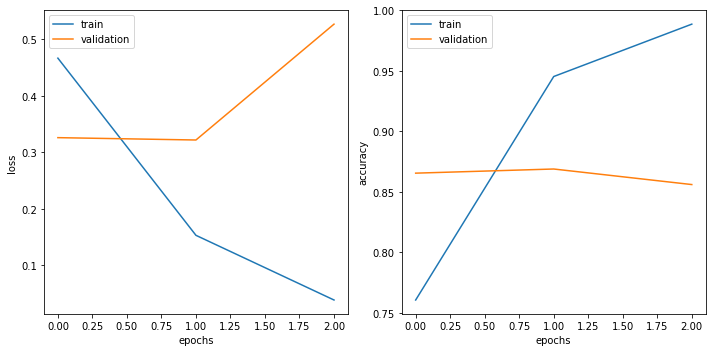

In [9]:
def plot_training_curves(history):
  plt.figure(figsize=(10, 5))

  plt.subplot(1, 2, 1)
  plt.plot(history.history["loss"], label="train")
  plt.plot(history.history["val_loss"], label="validation")
  plt.xlabel("epochs")
  plt.ylabel("loss")
  plt.legend(loc="best")

  plt.subplot(1, 2, 2)  
  plt.plot(history.history["accuracy"], label="train")
  plt.plot(history.history["val_accuracy"], label="validation")
  plt.xlabel("epochs")
  plt.ylabel("accuracy")
  plt.legend(loc="best")


  plt.tight_layout()
  _ = plt.show()


plot_training_curves(history_1)

In [10]:
model_1s = keras.models.load_model("/tmp/model_1")
scores_1 = model_1s.evaluate(Xtest, ytest)
print("Test loss: {:.3f}, accuracy: {:.3f}".format(scores_1[0], scores_1[1]))

195/195 [==============================] - 14s 69ms/step - loss: 0.3313 - accuracy: 0.8576
Test loss: 0.331, accuracy: 0.858


## Word Embeddings

Word embeddings project words into a geometric hyperspace where semantically similar words are close to each other.

One way to build word embeddings is the skip-gram network, used by [Word2Vec](https://en.wikipedia.org/wiki/Word2vec), where the objective is to predict if a pair of words co-occur together within a short span of each other.

Labeled data is plentiful for this, since we can use the words in sentences from readily available texts.

Another way to build these embeddings is to factorize a word co-occurrence matrix built from a large corpus of text, which is the approach used by [Global Vectors for Word Representation (GloVe)](https://nlp.stanford.edu/projects/glove/).

In the next example, we will show how to initialize the embedding matrix with GloVe vectors instead of random vectors.

The intuition here is that our network will benefit from the additional knowledge about word semantics that the GloVe vectors have learned during their training.

We populate the weight matrix of the `Embedding` layer, that would ordinarily be populated with some initialization technique, with weights from the pre-trained GloVe vectors.

`Embedding` layer's weight matrix projects the sparse vector representing a token in 1-hot encoded vocabulary space to a dense vector of smaller dimensions (300 in our case).

Idea is to create a `(vocab_size, 300)` vector where each row represents the GloVe vector for the word referenced by that id in the vocabulary.

This is a primitive form of Transfer Learning that was popular pre-2019 in NLP.

In [11]:
%%bash
(
  if [ ! -f glove.6B.300d.txt ]; then
    echo "Downloading glove..."
    wget --quiet http://nlp.stanford.edu/data/glove.6B.zip
    unzip -a glove.6B.zip
    rm glove.6B.zip glove.6B.50d.txt glove.6B.100d.txt glove.6B.200d.txt
  fi
)

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        [text]  
  inflating: glove.6B.100d.txt       [text]  
  inflating: glove.6B.200d.txt       [text]  
  inflating: glove.6B.300d.txt       [text]  


In [12]:
embedding_matrix = np.zeros((len(word2idx), 300))
with open("glove.6B.300d.txt", "r") as f:
  for line in f:
    cols = line.strip().split()
    word = cols[0]
    try:
      word_id = word2idx[word]
      word_vector = np.array([float(v) for v in cols[1:]])
      embedding_matrix[word_id] = word_vector
    except KeyError:
      continue

embedding_matrix.shape

(20002, 300)

In [13]:
def build_model_2():
  inputs = keras.Input(shape=(MAX_SEQUENCE_LENGTH,), dtype="int32")
  # project input from vocab id to 300d embedding space, specify input length
  x = keras.layers.Embedding(len(word2idx), 300, 
                             input_length=MAX_SEQUENCE_LENGTH,
                             weights=[embedding_matrix],
                             mask_zero=True)(inputs)
  # embedding vector for each input token feeds into Bidirectional LSTM of
  # hidden size 64 (since bidirectional 64*2 = 128)
  x = keras.layers.Bidirectional(keras.layers.LSTM(64))(x)
  # context vector from LSTM (return_sequences=False) into Dense binary classifier
  outputs = keras.layers.Dense(1, activation="sigmoid")(x)

  model = keras.models.Model(inputs, outputs)

  model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

  return model


model_2 = build_model_2()
model_2.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 128, 300)          6000600   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               186880    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 6,187,609
Trainable params: 6,187,609
Non-trainable params: 0
_________________________________________________________________


In [14]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss")
model_checkpoint = keras.callbacks.ModelCheckpoint("/tmp/model_2", 
                                                   monitor="val_loss", 
                                                   save_best_only=True)
history_2 = model_2.fit(Xtrain, ytrain, batch_size=32, epochs=5, 
                        validation_split=0.2,
                        callbacks=[early_stopping, model_checkpoint])

Epoch 1/5
146/146 [==============================] - 107s 734ms/step - loss: 0.6295 - accuracy: 0.6434 - val_loss: 0.4475 - val_accuracy: 0.8021
Epoch 2/5
146/146 [==============================] - 105s 720ms/step - loss: 0.3205 - accuracy: 0.8680 - val_loss: 0.3776 - val_accuracy: 0.8338
Epoch 3/5
146/146 [==============================] - 87s 594ms/step - loss: 0.1079 - accuracy: 0.9623 - val_loss: 0.3783 - val_accuracy: 0.8518


In [15]:
model_2s = keras.models.load_model("/tmp/model_2")
scores_2 = model_2s.evaluate(Xtest, ytest)
print("Test loss: {:.3f}, accuracy: {:.3f}".format(scores_2[0], scores_2[1]))

195/195 [==============================] - 13s 69ms/step - loss: 0.3943 - accuracy: 0.8263
Test loss: 0.394, accuracy: 0.826


## Transformer Embeddings

Post 2019, with the move towards Language Model based embeddings such as ULMFit, BERT, etc., Transfer Learning for NLP generally means using a Language Model as a source of embeddings.

Embeddings from Transformers are context-sensitive (i.e., the token "bank" in a sentences with "robbery" and "river" have different embeddings).

This is because of the self-attention mechanism in Transformers.

Net effect is that we no longer need a LSTM layer to encode the sequence, the transformer embedding takes care of that, so we only need the transformer between the input sequence and our classifier head (the `Dense` layer in `model_1` and `model_2`).

The sequence can be input directly into the Transformer module directly, and the output of the Transformer can be passed into a Dense layer.

The [Huggingface Transformers Library](https://huggingface.co/transformers/index.html) provides a library for working with Transformers in Pytorch and Keras/Tensorflow, as well as many pre-trained Transformer models.

In [16]:
!pip install transformers

     |████████████████████████████████| 1.3MB 11.4MB/s 
     |████████████████████████████████| 1.1MB 53.7MB/s 
     |████████████████████████████████| 890kB 54.5MB/s 
     |████████████████████████████████| 2.9MB 54.9MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893257 sha256=e7840e75213953f6836a839c2d0b63eb8abde1a759dccb5bed9dc6625e0460fb
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses


In [17]:
from transformers import TFBertModel, BertTokenizer

In [18]:
def get_transformer_compatible_inputs(X, tokenizer, idx2word):
  input_ids, seg_ids, mask_ids = [], [], []
  for i in range(X.shape[0]):
    # we want to use the BERT vocab, so we need to map our vocab to BERTs
    x_str = [idx2word[x] for x in X[i]]
    # convert __PAD__ and __OOV__ to BERT equivalent
    x_str = [(tokenizer.pad_token if x == "__PAD__" else x) for x in x_str]
    x_str = [(tokenizer.unk_token if x == "__OOV__" else x) for x in x_str]
    # convert back to BERT vocab ids
    x_ids = tokenizer.convert_tokens_to_ids(x_str)
    # now generate the input_ids, seg_ids (token_type_ids) and mask
    input_ids.append(np.array(tokenizer.build_inputs_with_special_tokens(x_ids)))
    mask_ids.append(np.array(tokenizer.get_special_tokens_mask(x_ids)))
    seg_ids.append(np.array(tokenizer.create_token_type_ids_from_sequences(x_ids)))
  return [np.array(input_ids, dtype=np.int32),
          np.array(mask_ids, dtype=np.int32),
          np.array(seg_ids, dtype=np.int32)]


tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

Xtr_train = get_transformer_compatible_inputs(Xtrain, tokenizer, idx2word)
print("train:", Xtr_train[0].shape, Xtr_train[1].shape, Xtr_train[2].shape, ytrain.shape)
Xtr_test = get_transformer_compatible_inputs(Xtest, tokenizer, idx2word)
print("test:", Xtr_test[0].shape, Xtr_test[1].shape, Xtr_test[2].shape, ytest.shape)


train: (5833, 130) (5833, 130) (5833, 130) (5833, 1)
test: (6228, 130) (6228, 130) (6228, 130) (6228, 1)


In [19]:
# adding the [CLS] and [SEP] tokens to input
MAX_SEQUENCE_LENGTH = MAX_SEQUENCE_LENGTH + 2

def build_model_3():
  # different from other build_* in that we will need to rebuild model
  # for inference again, so removing the compile step since no training needed
  token_inputs = keras.layers.Input((MAX_SEQUENCE_LENGTH), dtype=tf.int32, name='input_word_ids')
  mask_inputs = keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_masks')
  seg_inputs = keras.layers.Input((MAX_SEQUENCE_LENGTH,), dtype=tf.int32, name='input_segments')

  bert_model = TFBertModel.from_pretrained("bert-base-uncased")
  seq_output, _ = bert_model([token_inputs, mask_inputs, seg_inputs])
  x = keras.layers.GlobalAveragePooling1D()(seq_output)
  x = keras.layers.Dense(100, activation="relu")(x)
  output = keras.layers.Dense(1, activation="sigmoid", name="output")(x)
  model = keras.models.Model([token_inputs, mask_inputs, seg_inputs], output)

  return model


model_3 = build_model_3()

adam = keras.optimizers.Adam(lr=5e-5)
model_3.compile(optimizer=adam, loss='binary_crossentropy')

model_3.summary()

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 130)]        0                                            
__________________________________________________________________________________________________
input_masks (InputLayer)        [(None, 130)]        0                                            
__________________________________________________________________________________________________
input_segments (InputLayer)     [(None, 130)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     ((None, 130, 768), ( 109482240   input_word_ids[0][0]             
                                                                 input_masks[0][0]     

In [20]:
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss")
model_checkpoint = keras.callbacks.ModelCheckpoint("/tmp/model_3", 
                                                   monitor="val_loss", 
                                                   save_best_only=True,
                                                   save_weights_only=True)
history_3 = model_3.fit(Xtr_train, ytrain, batch_size=32, epochs=5, 
                        validation_split=0.2,
                        callbacks=[early_stopping, model_checkpoint])

Epoch 1/5
146/146 [==============================] - 140s 961ms/step - loss: 0.7070 - val_loss: 0.6762
Epoch 2/5
146/146 [==============================] - 140s 956ms/step - loss: 0.6624 - val_loss: 0.6111
Epoch 3/5
146/146 [==============================] - 139s 953ms/step - loss: 0.5763 - val_loss: 0.4688
Epoch 4/5
146/146 [==============================] - 139s 954ms/step - loss: 0.4453 - val_loss: 0.4088
Epoch 5/5
146/146 [==============================] - 134s 918ms/step - loss: 0.3292 - val_loss: 0.4132


In [22]:
model_3s = build_model_3()
model_3s.load_weights("/tmp/model_3").expect_partial()
model_3s.compile(optimizer=adam, loss='binary_crossentropy')

scores_3 = model_3s.evaluate(Xtr_test, ytest)
print("Test accuracy: {:.3f}".format(scores_3))

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


195/195 [==============================] - 56s 288ms/step - loss: 0.4290
Test accuracy: 0.429
